In [1]:
import os
import re
import json
import operator
from collections import defaultdict

import yaml
import requests
import pandas

API_URL = "https://api.jujucharms.com/charmstore/v5"

In [2]:
def filename(charmname, type):
    return "cached/{}/{}.json".format(type, charmname.replace('/',':'))


def cache_charm_list():
    resp = requests.get(API_URL + '/list?type=charm')
    charms = resp.json()['Results']
    with open('cached/charm-list-cached.json', 'w') as f:
        json.dump(charms, f, indent=4)


def get_charms():
    with open('cached/charm-list-cached.json', 'r') as f:
        charms = json.load(f)
    return [charm['Id'][3:] for charm in charms]


def cache_layer_files():
    charms = get_charms()
    numreactive = 0
    for name in charms:
        
        if os.path.isfile(filename(name, 'layer-yaml')):
            with open(filename(name, 'layer-yaml'), 'r') as f:
                if not "ArchiveDownloadCount" in f.read():
                    if "ceph" in name:
                        print(name)
                    continue
        else:
            continue
        print("getting doing charm {}".format(name))
        resp = requests.get("{}/{}/archive/layer.yaml".format(API_URL, name))
        if resp.status_code == 200:
            numreactive += 1
            layer = yaml.load(resp.text)
            with open(filename(name, 'layer-yaml'), 'w') as f:
                json.dump(layer, f, indent=4)
        else:
            os.remove(filename(name, 'layer-yaml'))
    print("Total charms: {}\nReactive charms: {}".format(len(charms), numreactive))


In [3]:
def cache_metrics():
    charms = get_charms()
    for name in charms:
        if not os.path.isfile(filename(name, 'metrics')):
            resp = requests.get("{}/{}/meta/stats".format(API_URL, name))
            if resp.status_code == 200:
                layer = yaml.load(resp.text)
                with open(filename(name, 'metrics'), 'w') as f:
                    json.dump(layer, f, indent=4)

    
cache_metrics()

In [288]:
#cache_charm_list()
cache_layer_files()
#cache_metrics()

getting doing charm ~1chb1n/ceph-0
getting doing charm ~1chb1n/ceph-mon-0
getting doing charm ~1chb1n/ceph-osd-0
getting doing charm ~1chb1n/mongodb-1
getting doing charm ~1chb1n/nova-compute-1
getting doing charm ~1chb1n/xenial/ganglia-0
getting doing charm ~1chb1n/xenial/ganglia-node-0
getting doing charm ~4-ja-d/oneiric/appflower-0
getting doing charm ~aabbasi/trusty/plumgrid-director-0
getting doing charm ~aabed/oneiric/gunicorn-0
getting doing charm ~abdullah-khan/trusty/plumgrid-director-0
getting doing charm ~abentley/precise/apache2-reverseproxy-5
getting doing charm ~abentley/precise/charmworld-8
getting doing charm ~abentley/precise/external-jenkins-0
getting doing charm ~abentley/precise/jenkins-lxc-2
getting doing charm ~abentley/precise/packages-3
getting doing charm ~abentley/trusty/apache2-reverseproxy-4
getting doing charm ~abentley/trusty/packages-0
getting doing charm ~abotcharm/trusty/abot-analytics-3
getting doing charm ~abotcharm/trusty/abot-epc-basic-1
getting doi

getting doing charm ~alexey-pustovalov/trusty/zabbix-proxy-0
getting doing charm ~alexey-pustovalov/trusty/zabbix-server-0
getting doing charm ~alexlist/precise/bittornado-2
getting doing charm ~alexlist/precise/pgbouncer-1
getting doing charm ~alexlist/precise/postgresql-1
getting doing charm ~alexlist/precise/squid-forwardproxy-10
getting doing charm ~alexlist/precise/squid-reverseproxy-6
getting doing charm ~alltheseletters/trusty/kubernetes-0
getting doing charm ~alltheseletters/trusty/kubernetes-master-0
getting doing charm ~aluria/trusty/cinder-backup-0
getting doing charm ~ameetp/precise/vdbench-5
getting doing charm ~ana-tomic/trusty/spagobi-9
getting doing charm ~andreserl/precise/maas-cluster-0
getting doing charm ~andreserl/precise/maas-region-1
getting doing charm ~andreserl/quantal/hacluster-0
getting doing charm ~andrewsomething/precise/bzr-and-loggerhead-0
getting doing charm ~andybavier/trusty/neutron-api-1
getting doing charm ~andybavier/trusty/neutron-gateway-3
gettin

In [4]:
def get_layer_yaml(name):
    path = filename(name, 'layer-yaml')
    try:
        with open(path, 'r') as f:
            layer_yaml = json.load(f)
            return layer_yaml
    except:
        return None

    
def get_reactive_charms():
    reactive_charms = []
    for name in get_charms():
        if os.path.isfile(filename(name, 'layer-yaml')):
            reactive_charms.append(name)
    return reactive_charms
  

def remove_version(name):
    name = re.sub('(-[0-9]+$)', '', name)
    return name
    
    
def normalize(name):
    name = name.split('/')[-1]
    name = remove_version(name)
    return name

def get_normalized_deps():
    deps = defaultdict(set)
    for name in get_reactive_charms():
        n_name = normalize(name)
        layer_yaml = get_layer_yaml(name)
        deps[n_name].update(set(layer_yaml.get('includes', [])))
    return deps

def get_deps():
    layers = defaultdict(list)
    interfaces = defaultdict(list)

    deps = get_normalized_deps()

    for name in deps:
        for incl in list(deps[name]):
            type, l_name = incl.split(':')
            if type in ('layer', 'cs'):
                if l_name != "basic":
                    layers[l_name].append(name)
            elif type == 'interface':
                interfaces[l_name].append(name)
            else:
                print("type {} not known".format(type))
    return (layers, interfaces)

def generate_usage():
    layers, interfaces = get_deps()

    sorted_layers = sorted(layers.items(), key=lambda itempair: len(itempair[1]), reverse=True)
    sorted_interfaces = sorted(interfaces.items(), key=lambda itempair: len(itempair[1]), reverse=True)

    l_counts = {name: len(layers[name]) for name in layers}
    i_counts = {name: len(interfaces[name]) for name in interfaces}
    sorted_l_counts = sorted(l_counts.items(), key=operator.itemgetter(1), reverse=True)
    sorted_i_counts = sorted(i_counts.items(), key=operator.itemgetter(1), reverse=True)


    with open('cached/layer-usage-raw', 'w') as f:
        json.dump(sorted_layers, f, indent=4)
    with open('cached/interface-usage-raw', 'w') as f:
        json.dump(sorted_interfaces, f, indent=4)

    with open('cached/layer-usage', 'w') as f:
        json.dump(sorted_l_counts, f, indent=4)
    with open('cached/interface-usage', 'w') as f:
        json.dump(sorted_i_counts, f, indent=4)

        
generate_usage()

In [92]:
# layer_data = pandas.read_json(
#     'cached/layer-usage',
# )
# interface_data = pandas.read_json(
#     'cached/interface-usage',
# )
# layer_data_raw  = pandas.read_json(
#     'cached/layer-usage-raw',
# )
# interface_data_raw = pandas.read_json(
#     'cached/interface-usage-raw',
# )

In [91]:
# import numpy as np
# from datetime import timedelta
# import matplotlib.pyplot as plt


# def create_sane_figure():
#     # You typically want your plot to be ~1.33x wider than tall.
#     # Common sizes: (10, 7.5) and (12, 9)
#     fig = plt.figure(figsize=(12, 6))  # a new figure window
#     ax = fig.add_subplot(1, 1, 1)      # specify (nrows, ncols, axnum)

#     # Put the axis behind the datapoints
#     ax.set_axisbelow(True)
#     # Grey ticks, labels, and axis'
#     for spine in ax.spines.values():
#         spine.set_color('black')
#     for line in ax.get_xticklines() + ax.get_yticklines():
#         line.set_color('black')
#     ax.set_xlabel(None, fontsize=16, color='black')
#     ax.set_ylabel(None, fontsize=16, color='black')
#     # Don't show a grid
#     ax.grid(False)
#     # remove top and right border of graph
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)
#     ax.tick_params(
#         axis='both', which='both',
#         labelsize=14, labelcolor='black',
#         color='black')
#     # Make the title big enough so it spans the entire plot, but don't make it
#     # so big that it requires two lines to show.
#     ax.set_title(None, fontsize=22, color='black')
#     return (fig, ax)

In [90]:
# %matplotlib inline

# def create_layer_usage():
#     (fig, ax) = create_sane_figure()

#     ax.set_title("Usage of layers", fontsize=22)
#     ax.set_xlabel("Name of layer")
#     ax.set_ylabel("Number of layers using this layer")

#     ax.set_xticks(range(0, 101, 20))
#     ax.set_yticks(np.arange(0, 1000, 50))

# #     # Now put the actual data in the plot
# #     ax.errorbar(
# #         final.clusters, final['mean'],
# #         yerr=final['std'],
# #         label="concurrency potential",
# #         linestyle='None',
# #         capsize=5,
# #         fmt='o',
 
# #     )
#     asa = ax.bar(range(len(data[0])), data[1], tick_label=data[0])
#     ax.set_yscale('log')
# #     ax.plot(
# #         data[0], data[1],'o',
# #     )
# #     ax.plot(
# #         data2['clustrs'], data2['elapsed_time'],'o', color="black"
# #     )
#     # Save the plot to a file
#     # fig.savefig("multiple_soy_clusters.png", bbox_inches="tight")
#     fig.savefig("layer_usage.pdf", bbox_inches="tight")
#     fig.show()
# create_layer_usage()


In [89]:
# %matplotlib inline

# def create_interface_usage():
#     (fig, ax) = create_sane_figure()

#     ax.set_title("Usage of interfaces", fontsize=22)
#     ax.set_xlabel("Name of interface")
#     ax.set_ylabel("Number of layers using this interface")

#     ax.set_xticks(range(0, 101, 20))
#     ax.set_yticks(np.arange(0, 1000, 50))

# #     # Now put the actual data in the plot
# #     ax.errorbar(
# #         final.clusters, final['mean'],
# #         yerr=final['std'],
# #         label="concurrency potential",
# #         linestyle='None',
# #         capsize=5,
# #         fmt='o',
 
# #     )
#     asa = ax.bar(range(len(interface_data[0])), interface_data[1], tick_label=interface_data[0])
#     ax.set_yscale('log')
# #     ax.plot(
# #         data[0], data[1],'o',
# #     )
# #     ax.plot(
# #         data2['clustrs'], data2['elapsed_time'],'o', color="black"
# #     )
#     # Save the plot to a file
#     # fig.savefig("multiple_soy_clusters.png", bbox_inches="tight")
#     fig.savefig("interface_usage.pdf", bbox_inches="tight")
#     fig.show()
    

# create_interface_usage()

In [88]:
# layer_percents = pandas.cut(layer_data[1], [0,1,2,10,100,1000]).value_counts(normalize=True)*100

# fig = plt.figure(figsize=(12, 6))  # a new figure window
# ax = fig.add_subplot(1, 1, 1) 
# ax.pie(layer_percents, labels=['1','2','3-10','11-100','>100'], autopct='%1.1f%%')
# ax.axis('equal') 
# ax.set_title("Usage of dependencies (layers)", fontsize=22)

# fig.show()

In [87]:
# interface_percents = pandas.cut(interface_data[1], [0,1,2,10,50]).value_counts(normalize=True)*100

# fig = plt.figure(figsize=(12, 6))  # a new figure window
# ax = fig.add_subplot(1, 1, 1) 
# ax.pie(interface_percents, labels=['1','2','3-10','>10'], autopct='%1.1f%%')
# ax.axis('equal') 
# ax.set_title("Usage of dependencies (interfaces)", fontsize=22)

# fig.show()


In [86]:
# layer_usage = pandas.cut(layer_data[1], [0,1,2,10,100,1000]).value_counts()
# indexed_layer_data = layer_data.set_index(0)



# charm_used_deps = defaultdict(list)

# charms = get_normalized_deps()

# for charm_name in charms:
#     charm_used_deps[charm_name]
#     for include in list(charms[charm_name]):
#         dep_type, dep_name = include.split(':')
#         if dep_type in ('layer', 'cs'):
#             if dep_name != "basic":
#                 if indexed_layer_data.at[dep_name,1] >=2:
#                     charm_used_deps[charm_name].append(dep_name)


                
# counts = pandas.DataFrame([len(charm_used_deps[l]) for l in charm_used_deps])                
# layer_percents = pandas.cut(
#     counts[0],
#     [-1,0,1,2,3,4,100],
# ).value_counts(normalize=True)*100

# fig = plt.figure(figsize=(12, 6))  # a new figure window
# ax = fig.add_subplot(1, 1, 1) 
# ax.pie(layer_percents, labels=['0','1','2','3','4', '>4'], autopct='%1.1f%%')
# ax.axis('equal') 
# ax.set_title("Number of reused dependencies per charm (layers)", fontsize=22)

# fig.show()


In [12]:
#
# {
#     "ArchiveDownloadCount": 41,
#     "ArchiveDownload": {
#         "Total": 41,
#         "Day": 0,
#         "Week": 0,
#         "Month": 0
#     },
#     "ArchiveDownloadAllRevisions": {
#         "Total": 41,
#         "Day": 0,
#         "Week": 0,
#         "Month": 0
#     }
# }
#

def get_metrics(name):
    path = filename(name, 'metrics')
    try:
        with open(path, 'r') as f:
            metrics = json.load(f)
            return metrics
    except:
        return None

def get_active_reactive_charms():    
    ms = defaultdict(dict)

    for charm in get_reactive_charms():
        name = normalize(charm)
        metrics = get_metrics(charm)
        ms[name]['Total'] = metrics['ArchiveDownloadAllRevisions']['Total']
        ms[name]['Day'] = metrics['ArchiveDownloadAllRevisions']['Day']
        ms[name]['Week'] = metrics['ArchiveDownloadAllRevisions']['Week']
        ms[name]['Month'] = metrics['ArchiveDownloadAllRevisions']['Month']

    metrics_t = pandas.DataFrame(ms)
    pivot = metrics_t.loc['Month']

    return list(pivot[pivot > 0].index)

#get_active_reactive_charms()


# layer_data_raw  = pandas.read_json(
#     'cached/layer-usage-raw',
# )
# interface_data_raw = pandas.read_json(
#     'cached/interface-usage-raw',
# )

In [77]:
# layer_usage = pandas.cut(layer_data[1], [0,1,2,10,100,1000]).value_counts()
# indexed_layer_data = layer_data.set_index(0)



# charm_used_deps = defaultdict(list)

# charms = get_normalized_deps()
# active_charms = get_active_reactive_charms()

# for charm_name in charms:
#     if charm_name in active_charms:
#         charm_used_deps[charm_name]
#         for include in list(charms[charm_name]):
#             dep_type, dep_name = include.split(':')
#             if dep_type in ('layer', 'cs'):
#                 if dep_name != "basic":
#                     if indexed_layer_data.at[dep_name,1] >=2:
#                         charm_used_deps[charm_name].append(dep_name)


                
# counts = pandas.DataFrame([len(charm_used_deps[l]) for l in charm_used_deps])                
# layer_percents = pandas.cut(
#     counts[0],
#     [-1,0,1,2,3,100],
# ).value_counts(normalize=True)*100

# fig = plt.figure(figsize=(12, 6))  # a new figure window
# ax = fig.add_subplot(1, 1, 1) 
# ax.pie(layer_percents, labels=['0','1','2','3','>3'], autopct='%1.1f%%')
# ax.axis('equal') 
# ax.set_title("Number of reused dependencies per USED charm (layers)", fontsize=22)

# fig.show()

In [15]:
def get_grouped_includes(dependencies):
    '''converts a list of includes into two lists of includes: (layers, interfaces)
    '''
    layers = []
    interfaces = []
    for incl in dependencies or []:
        type, l_name = incl.split(':')
        if type in ('layer', 'cs'):
            layers.append(l_name)
        elif type == 'interface':
            interfaces.append(l_name)
        else:
            print("type {} not known".format(type))
    return (layers, interfaces)


charms = {k:{} for k in get_charms()}

for charm_name in charms:
    # If a charm has a layer.yaml file, it's a reactive charm
    # Add dependencies of the reactive charm
    layer_yaml = get_layer_yaml(charm_name)
    if layer_yaml:
        charms[charm_name]['reactive'] = True
        (
            charms[charm_name]['include-layers'],
            charms[charm_name]['include-interfaces'],
        ) = get_grouped_includes(layer_yaml.get('includes'))
    else:
        charms[charm_name]['reactive'] = False
        charms[charm_name]['include-layers'] = []
        charms[charm_name]['include-interfaces'] = []
        
    # Add the metrics for each charm
    charms[charm_name]['downloads-day'] = get_metrics(charm_name).get('ArchiveDownloadAllRevisions')['Day']
    charms[charm_name]['downloads-week'] = get_metrics(charm_name).get('ArchiveDownloadAllRevisions')['Week']
    charms[charm_name]['downloads-month'] = get_metrics(charm_name).get('ArchiveDownloadAllRevisions')['Month']
    charms[charm_name]['downloads-total'] = get_metrics(charm_name).get('ArchiveDownloadAllRevisions')['Total']
    
    # Add the normalized name for each charm
    charms[charm_name]['name-normalized'] = normalize(charm_name)
    
    # Add the versionless name for each charm
    charms[charm_name]['name-versionless'] = remove_version(charm_name)


# Get a table where rows, the keys from the dict are the index of the table    
charmstable = pandas.DataFrame.from_dict(charms, orient='index')
charmstable.sort_values('downloads-month', inplace=True, ascending=False)

charmstable.head(50)

,reactive,include-layers,include-interfaces,downloads-day,downloads-week,downloads-month,downloads-total,name-normalized,name-versionless
keystone-273,False,[],[],68,590,3233,113113,keystone,keystone
rabbitmq-server-70,False,[],[],68,592,3208,154702,rabbitmq-server,rabbitmq-server
percona-cluster-257,False,[],[],70,565,3125,78465,percona-cluster,percona-cluster
glance-261,False,[],[],68,580,3113,100037,glance,glance
nova-cloud-controller-304,False,[],[],71,585,3072,105079,nova-cloud-controller,nova-cloud-controller
mongodb-46,False,[],[],62,557,2892,50277,mongodb,mongodb
mongodb-42,False,[],[],62,557,2892,50277,mongodb,mongodb
ntp-25,False,[],[],62,563,2871,79399,ntp,ntp
openstack-dashboard-255,False,[],[],53,586,2592,94642,openstack-dashboard,openstack-dashboard
nova-compute-280,False,[],[],58,458,2551,98120,nova-compute,nova-compute


In [16]:
versionless_charmstable = charmstable.groupby(
    'name-versionless'
).agg({
    'reactive': lambda x: x.max(),
    'include-layers': lambda x: list(set(x.sum())),
    'include-interfaces': lambda x: list(set(x.sum())),
    'downloads-day': lambda x: x[0],
    'downloads-week': lambda x: x[0],
    'downloads-month': lambda x: x[0],
    'downloads-total': lambda x: x[0],
    'name-normalized': lambda x: x[0],
})

versionless_charmstable.head()

versionless_charmstable.sort_values('downloads-month', inplace=True, ascending=False)
versionless_charmstable.head()

#versionless_charmstable.loc[versionless_charmstable['name-normalized'] == "mongodb"].head()

,reactive,include-layers,include-interfaces,downloads-day,downloads-week,downloads-month,downloads-total,name-normalized
name-versionless,,,,,,,,
keystone,False,[],[],68,590,3233,113113,keystone
rabbitmq-server,False,[],[],68,592,3208,154702,rabbitmq-server
percona-cluster,False,[],[],70,565,3125,78465,percona-cluster
glance,False,[],[],68,580,3113,100037,glance
nova-cloud-controller,False,[],[],71,585,3072,105079,nova-cloud-controller


In [17]:
# 

normalized_charmstable = versionless_charmstable.loc[
    versionless_charmstable['downloads-month'] >0        # remove all charms that aren't used
].groupby(     
    'name-normalized'                                    # Group by their charmname (without namespace)
).agg({
    'reactive': lambda x: x.max(),                       # If one of them is reactive, count them all as reactive
    'include-layers': lambda x: list(set(x.sum())),      # Merge all layer dependencies
    'include-interfaces': lambda x: list(set(x.sum())),  # Merge all interface dependencies
    'downloads-day': lambda x: x.sum(),                  # sum all downloads
    'downloads-week': lambda x: x.sum(),
    'downloads-month': lambda x: x.sum(),
    'downloads-total': lambda x: x.sum(),
})

normalized_charmstable.head()

normalized_charmstable.sort_values('downloads-month', inplace=True, ascending=False)
normalized_charmstable.head(50)


,reactive,include-layers,include-interfaces,downloads-day,downloads-week,downloads-month,downloads-total
name-normalized,,,,,,,
percona-cluster,False,[],[],115,1030,4953,130100
rabbitmq-server,False,[],[],102,999,4894,305092
glance,False,[],[],107,988,4726,176272
nova-cloud-controller,False,[],[],112,956,4499,192381
keystone,False,[],[],99,944,4431,205312
nova-compute,False,[],[],99,892,4291,186033
neutron-api,False,[],[],93,847,3920,151287
mongodb,False,[],[],95,834,3854,98319
openstack-dashboard,False,[],[],84,900,3820,166921


In [58]:
#
# Charms which are active (>0 downloads in last month)
#

activecharms = normalized_charmstable

print("Total Active Charms: {}"
      "\nRegular:             {}"
      "\nReactive:            {}"
      "\t({}%)".format(
          len(activecharms),
          len(activecharms.loc[activecharms['reactive'] == False]),
          len(activecharms.loc[activecharms['reactive'] == True]),
          activecharms['reactive'].mean()*100,
      )
)


Total Active Charms: 529
Regular:             353
Reactive:            176	(33.2703213610586%)


In [79]:
reactive_charm_names = normalized_charmstable.loc[normalized_charmstable['reactive'] == True].index.values

included_layers = defaultdict(lambda: defaultdict(list))
included_interfaces = defaultdict(lambda: defaultdict(list))

for charm_name in reactive_charm_names:
    charm = normalized_charmstable.loc[charm_name]
    for include_layer in charm['include-layers']:
        included_layers[include_layer]['charms'].append(charm_name)
    for include_interface in charm['include-interfaces']:
        included_interfaces[include_interface]['charms'].append(charm_name) 
        
included_layers = pandas.DataFrame.from_dict(included_layers, orient='index')
included_layers['num-charms'] = included_layers['charms'].apply(len)


included_interfaces = pandas.DataFrame.from_dict(included_interfaces, orient='index')
included_interfaces['num-charms'] = included_interfaces['charms'].apply(len)

included_layers.head()

,charms,num-charms
6wind-common,"[virtual-accelerator-network, virtual-accelera...",2
apache-bigtop-base,"[hadoop-plugin, hadoop-namenode, hadoop-slave,...",14
apache-flume-base,"[apache-flume-hdfs, apache-flume-kafka, apache...",3
apache-hadoop-datanode,[apache-hadoop-slave],1
apache-hadoop-nodemanager,[apache-hadoop-slave],1


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


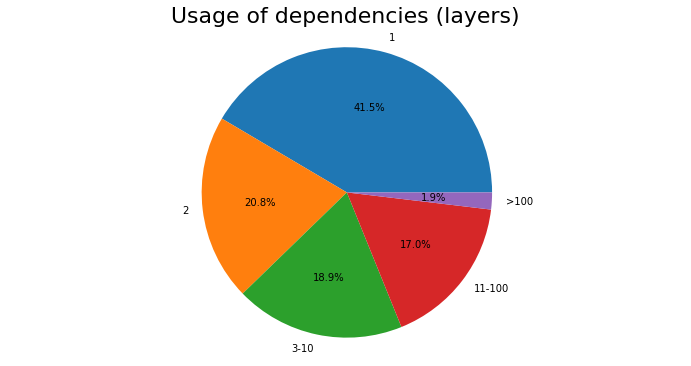

In [85]:
included_layer_buckets = pandas.cut(included_layers['num-charms'], [0,1,2,10,100,1000]).value_counts(normalize=True)*100

fig = plt.figure(figsize=(12, 6))  # a new figure window
ax = fig.add_subplot(1, 1, 1) 
ax.pie(included_layer_buckets, labels=['1','2','3-10','11-100','>100'], autopct='%1.1f%%')
ax.axis('equal') 
ax.set_title("Usage of dependencies (layers)", fontsize=22)

fig.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


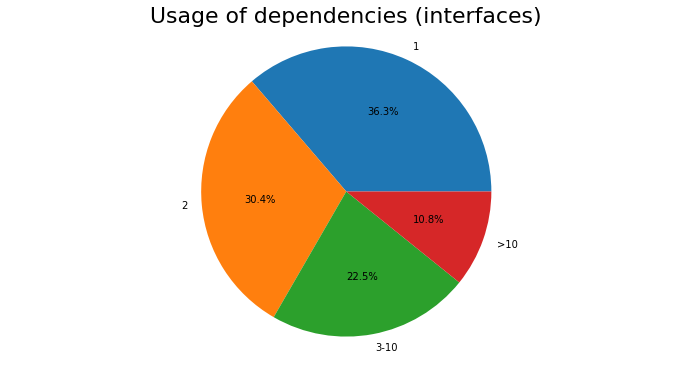

In [83]:
included_interfaces_buckets = pandas.cut(included_interfaces['num-charms'], [0,1,2,10,50]).value_counts(normalize=True)*100


fig = plt.figure(figsize=(12, 6))  # a new figure window
ax = fig.add_subplot(1, 1, 1) 
ax.pie(included_interfaces_buckets, labels=['1','2','3-10','>10'], autopct='%1.1f%%')
ax.axis('equal') 
ax.set_title("Usage of dependencies (interfaces)", fontsize=22)

fig.show()

In [80]:
normalized_charmstable['shared-interfaces'] = normalized_charmstable['include-interfaces'].apply(
    lambda x: [
        i_name for i_name in x
        if included_interfaces.loc[i_name]['num-charms'] > 1
    ])
normalized_charmstable['shared-layers'] = normalized_charmstable['include-layers'].apply(
    lambda x: [
        i_name for i_name in x
        if included_layers.loc[i_name]['num-charms'] > 1
    ])

normalized_charmstable.head()

,reactive,include-layers,include-interfaces,downloads-day,downloads-week,downloads-month,downloads-total,shared-layers,shared-interfaces
name-normalized,,,,,,,,,
percona-cluster,False,[],[],115,1030,4953,130100,[],[]
rabbitmq-server,False,[],[],102,999,4894,305092,[],[]
glance,False,[],[],107,988,4726,176272,[],[]
nova-cloud-controller,False,[],[],112,956,4499,192381,[],[]
keystone,False,[],[],99,944,4431,205312,[],[]


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


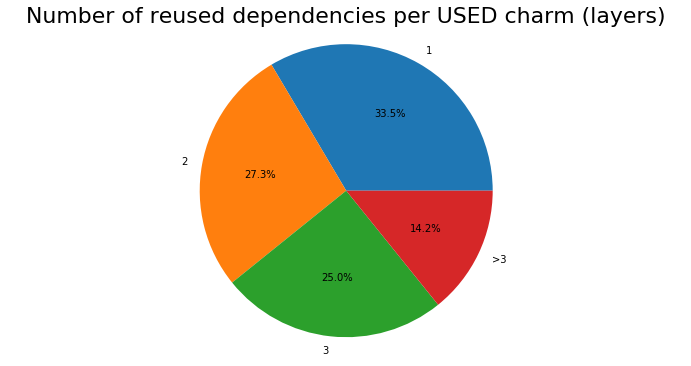

In [74]:
                
           
layer_percents = pandas.cut(
    normalized_charmstable.loc[
        activecharms['reactive'] == True
    ]['shared-layers'].apply(
        lambda x: len(x)
    ),
    [-1,1,2,3,100],
).value_counts(normalize=True)*100



fig = plt.figure(figsize=(12, 6))  # a new figure window
ax = fig.add_subplot(1, 1, 1) 
ax.pie(layer_percents, labels=['1','2','3','>3'], autopct='%1.1f%%')
ax.axis('equal') 
ax.set_title("Number of reused dependencies per USED charm (layers)", fontsize=22)

fig.show()


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


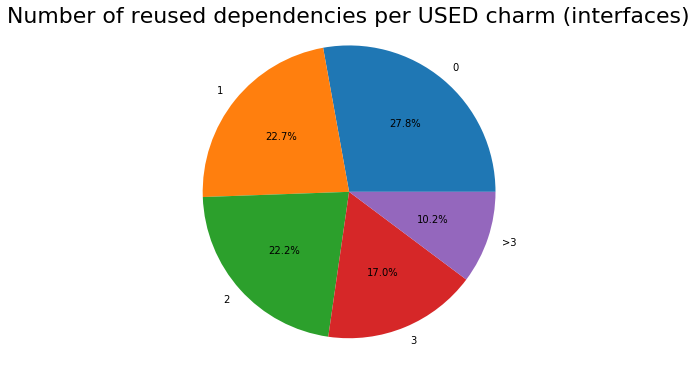

In [76]:
interface_percents = pandas.cut(
    normalized_charmstable.loc[
        activecharms['reactive'] == True
    ]['shared-interfaces'].apply(
        lambda x: len(x)
    ),
    [-1,0,1,2,3,100],
).value_counts(normalize=True)*100



fig = plt.figure(figsize=(12, 6))  # a new figure window
ax = fig.add_subplot(1, 1, 1) 
ax.pie(interface_percents, labels=['0', '1','2','3','>3'], autopct='%1.1f%%')
ax.axis('equal') 
ax.set_title("Number of reused dependencies per USED charm (interfaces)", fontsize=22)

fig.show()
